In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from PIL import Image
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import numpy as np
from tqdm import tqdm
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.utils import to_categorical
import itertools
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
label_data = pd.read_csv("../input/ucf101/UCF101TrainTestSplits-RecognitionTask/ucfTrainTestlist/classInd.txt", sep=' ', header=None)
label_data.columns=['index', 'labels']
print(label_data.shape)
label_data = label_data.drop(['index'], axis=1)
label_data.head()

(101, 2)


,labels
0,ApplyEyeMakeup
1,ApplyLipstick
2,Archery
3,BabyCrawling
4,BalanceBeam


In [4]:
print(label_data.shape)


(101, 1)


In [5]:
#Total Number of video folders for classification
len(label_data)

101

In [6]:
path=[]
for label in label_data.labels.values:
    path.append('../input/ucf101/UCF101/UCF-101/'+label+"/")
path[0]

'../input/ucf101/UCF101/UCF-101/ApplyEyeMakeup/'

In [7]:
print(len(path))

101


In [8]:
UCF101_frames = '/kaggle/working/UCF101_frames'

In [9]:
#n for loading video files, Process and store in a data set
def saving_the_frames(datasets):
    if not os.path.exists(UCF101_frames):
            os.mkdir(UCF101_frames)
    
    
    #Iterate through each fodler corresponding to category
    folders = os.listdir(datasets)
#     (folders)
#each class_name is one folder example ApplyEyeMakeup
    for class_name in folders:
#         print(class_name)
        image_folder_path = os.path.join('/kaggle/working/UCF101_frames',class_name)
#         print(image_folder_path)
        if not os.path.exists(image_folder_path):
            os.mkdir(image_folder_path)
        video_path =  os.path.join('/kaggle/input/ucf101/UCF101/UCF-101',class_name)
#         print(video_path)
        
        for video_file_name in os.listdir(video_path):
#             print(video_file_name)
            if '.avi' not in video_file_name:
                continue
            name, ext = os.path.splitext(video_file_name)
#             print(name)
            video_frame_folder_path = os.path.join(image_folder_path,name)
#             print(video_frame_folder_path)
            if not os.path.exists(video_frame_folder_path):
                os.mkdir(video_frame_folder_path)

In [10]:
saving_the_frames('/kaggle/input/ucf101/UCF101/UCF-101')

In [11]:
from PIL import Image

#Function for Feature Extraction
def feature_extraction(video_path):
    width=80
    height=60
    sequence_length=10
    frames_list=[]
    name, ext = os.path.splitext(video_path)
    video_name=os.path.basename(name)
    folderName =os.path.dirname(video_path)
    file_name = os.path.basename(folderName)
    #fileName is folder name i.e. class name
#     print(file_name)
#     print(video_name)
    #print(a)
    #Read the Video
    video_reader = cv2.VideoCapture(video_path)
    #get the frame count
    frame_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    #Calculate the interval after which frames will be added to the list
    skip_interval = max(int(frame_count/sequence_length), 1)
    #iterate through video frames
    for counter in range(sequence_length):
        #Set the current frame postion of the video
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, counter * skip_interval)
        #Read the current frame 
        ret, frame = video_reader.read()
        
        if not ret:
            break;
        #Resize the image
#         frame=cv2.resize(frame, (height, width))
#        print(frame.shape)
        #frame = frame/255
        #Append to the frame
        frames_list.append(frame)
        array=np.array(frame)
        new_image = Image.fromarray(array)
        new_image.save('/kaggle/working/UCF101_frames/'+file_name+'/'+video_name
                       +'/'+str(counter)+'.png')
#         print(len(frames_list))
    video_reader.release()
    #Return the Frames List
    return frames_list

In [12]:
#Function for loading video files, Process and store in a data set
def load_video(datasets):
    global image
    label_index=0
    labels=[]
    images=[]
    #Iterate through each foler corresponding to category
    for folder in datasets:
        images1 = []
        for file in tqdm(os.listdir(folder)):
            #Get the path name for each video
            video_path = os.path.join(folder, file)
            #Extract the frames of the current video
            frames_list = feature_extraction(video_path)
#             images2 = []
#             images2.append(frames_list)
            images.append(frames_list)
            labels.append(label_index)
#         images1.append(images1)
        label_index+=1
#     images.append(images1)
    return np.array(images, dtype='int16'), np.array(labels, dtype='int8')

In [13]:
#Due to memory allocation problem. I will select last 60 video folders for classification
images, labels = load_video(path[30:35])

100%|██████████| 140/140 [01:00<00:00,  2.33it/s]


In [14]:
#Shapes
images.shape, pd.Series(labels).shape

((672, 10, 240, 320, 3), (672,))

In [15]:
print(images[1])

[[[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  ...

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]]


 [[[0 0 0]
   [0 0 0]
   [0 0 0]
   ...
   [0 0 0]
   [0 0 0]
   [0 0 0]]

  [[0 0

In [16]:
def merging_frames(frames):
    frames1 = frames[0]
    frames2 = frames[1]
    frames3 = frames[2]
    frames4 = frames[3]
    frames5 = frames[4]
    merged_image = frames1+frames2+frames3+frames4+frames5
    print(merged_image)
    return merged_image

In [17]:
print(images[0].shape)

(10, 240, 320, 3)


In [18]:
actual_image = np.array(images[0][0], dtype=np.uint8)
actual_image_save = Image.fromarray(actual_image)
# print(new_image.shape)
actual_image_save.save('new3.png')

In [19]:
merged_image = merging_frames(images[0])

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [28]:
merged_image = merged_image//(5.0)


In [29]:
def merging_frames1(frames):
    frames1 = frames[0]
    frames2 = frames[1]
    frames3 = frames[2]
    frames4 = frames[3]
    frames5 = frames[4]
    merged_image = frames1*frames2*frames3*frames4*frames5
    print(merged_image)
    return merged_image

In [35]:
num=255
merged_image1 = merging_frames1(images[0])
merged_image1 = merged_image1//(num)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


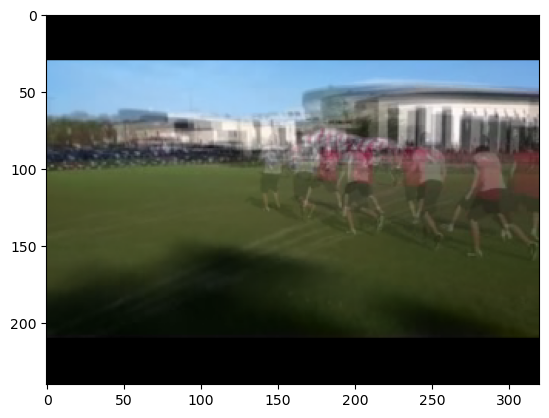

In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
an = np.array(merged_image.astype('uint8'))
an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB)
plt.imshow(an)
plt.show()

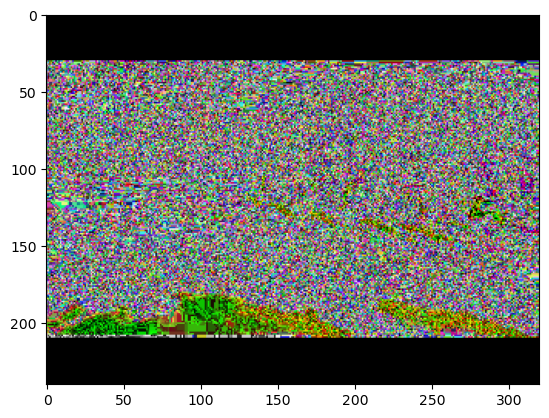

In [36]:
an = np.array(merged_image1.astype('uint8'))
an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB)
plt.imshow(an)
plt.show()

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


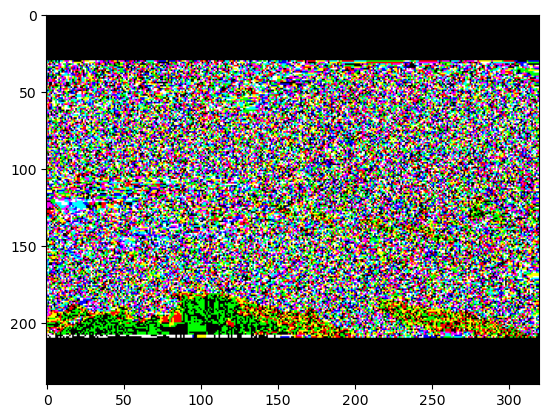

In [34]:
def merging_frames2(frames):
    frames1 = frames[0]
    frames2 = frames[1]
    frames3 = frames[2]
    frames4 = frames[3]
    frames5 = frames[4]
    merged_image = np.maximum(frames1,frames2)
    merged_image=np.maximum(merged_image,frames3)
    merged_image=np.maximum(merged_image,frames4)
    merged_image=np.maximum(merged_image,frames5)
    print(merged_image)
    return merged_image

num=255*255*255*255
merged_image2 = merging_frames2(images[0])
merged_image2 = merged_image2

an = np.array(merged_image1.astype('uint8'))
an = cv2.cvtColor(an, cv2.COLOR_BGR2RGB)
plt.imshow(an)
plt.show()

In [21]:
merged_frames = np.array(merged_image, dtype=np.uint8)

In [22]:
import cv2
merged_frames_rgb = cv2.cvtColor(merged_frames, cv2.COLOR_BGR2RGB)

In [23]:
# array = np.array(images[127][4], dtype=np.uint8)

In [24]:
new_image = Image.fromarray(merged_frames)
# print(new_image.shape)
new_image.save('new4.png')

In [25]:
# saving_the_frames(path)